In [1]:
# Input data
import numpy as np
from utilities import *

# test and train read
X_train_valid, Y_train_valid, list_ch_train_valid = read_data(data_path="../../../datasets/har/har-data/", 
                                                              split="train")
X_test, Y_test, list_ch_test = read_data(data_path="../../../datasets/har/har-data/", split="test")

assert list_ch_train_valid == list_ch_test, "Mistmatch in channels!"
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)

print(np.mean(Y_train_valid==0), np.mean(Y_train_valid==1), np.mean(Y_train_valid==2), 
      np.mean(Y_train_valid==3), np.mean(Y_train_valid==4), np.mean(Y_train_valid==5),
      np.mean(Y_train_valid==6), np.mean(Y_train_valid==7))

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0


In [2]:
# Preparing input and output data
# from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid).reshape(-1)==0), np.mean((Y_train_valid).reshape(-1)==1),
     np.mean((Y_train_valid).reshape(-1)==2), np.mean((Y_train_valid).reshape(-1)==3),
     np.mean((Y_train_valid).reshape(-1)==4), np.mean((Y_train_valid).reshape(-1)==5),
     np.mean((Y_train_valid).reshape(-1)==6), np.mean((Y_train_valid).reshape(-1)==7))

Y_train_valid_onehot = one_hot(labels=Y_train_valid.reshape(-1), n_class=6) 
Y_test_onehot = one_hot(labels=Y_test.reshape(-1), n_class=6) 

print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
      Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0
(7352, 6) float64 (2947, 6) float64


In [3]:
# Train and valid split
from sklearn.model_selection import train_test_split

X_train_norm, X_valid_norm, Y_train_onehot, Y_valid_onehot = train_test_split(X_train_valid_norm, 
                                                                              Y_train_valid_onehot,
                                                                              test_size=0.30)

print(X_train_norm.shape, X_valid_norm.shape, Y_train_onehot.shape, Y_valid_onehot.shape)

(5146, 128, 9) (2206, 128, 9) (5146, 6) (2206, 6)


In [4]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [5]:
# Input data which is divided into train, valid, and testing.
N, W, Cin = X_valid_norm.shape[0], X_train_norm.shape[1], X_train_norm.shape[2]
X = tf.placeholder(dtype=tf.float32, name=None, shape=[N, W, Cin])
print(X.shape, X.dtype)

# Output data/labels
assert Y_train_valid.max(axis=0)==Y_test.max(axis=0)
Cout = Y_train_valid.max(axis=0)
Y = tf.placeholder(dtype=tf.float32, name=None, shape=[N, Cout])
print(Y.shape, Y.dtype)

(2206, 128, 9) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [6]:
# One convolution layer
print(X.shape, X.dtype)
# NWC: N is not important for weights/filters/kernels since it is not being convolved.
Wwidth, Wchannels, Wnumber = X.shape[1].value//2, X.shape[2].value, X.shape[2].value*2
shape = [Wwidth, Wchannels, Wnumber]
initial_value = tf.random_normal(dtype=X.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
Wconv = tf.Variable(dtype=X.dtype, initial_value=initial_value, name=None, trainable=True)
print(Wconv.shape, Wconv.dtype)
Xconv = tf.nn.conv1d(data_format='NWC', filters=Wconv, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=X)
# Relu or nonlinearity/activation should also be implemnted
# leaky relu is what I am interested in which is the simplest possible non-linearity and gets the job easily done.
Xconv = tf.maximum(name=None, x=0.1*Xconv, y=1.0*Xconv)
print(Xconv.shape, Xconv.dtype)

(2206, 128, 9) <dtype: 'float32'>
(64, 9, 18) <dtype: 'float32_ref'>
(2206, 64, 18) <dtype: 'float32'>


In [9]:
# This is a multiplication layer/ dense/fully-connected/gobal
# shape = [-1, Xconv.shape[1].value*Xconv.shape[2].value] # N is None which is a value or creating an extra index
shape = [Xconv.shape[0].value, Xconv.shape[1].value*Xconv.shape[2].value]
Xconv_reshaped = tf.reshape(name=None, shape=shape, tensor=Xconv)
print(Xconv_reshaped.shape, Xconv_reshaped.dtype)
# print(Y.shape, Y.dtype)
# In this layer there is not very much 
# Wwidth, Wchannels, Wnumber which is for a normal conv layer
# NWC or WCN but for a dense layer, there is no W or H it is just CN or NC
Wchannels, Wnumber = Xconv_reshaped.shape[1].value, Y.shape[1].value
shape = [Wchannels, Wnumber]
# print(shape)
initial_value = tf.random_normal(dtype=Xconv_reshaped.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
W = tf.Variable(dtype=Xconv_reshaped.dtype, initial_value=initial_value, name=None, trainable=True)
print(W.shape, W.dtype)
logits = tf.matmul(a=Xconv_reshaped, b=W, name=None)
print(logits.shape, logits.dtype)
print(Y.shape, Y.dtype)

(2206, 1152) <dtype: 'float32'>
(1152, 6) <dtype: 'float32_ref'>
(2206, 6) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [14]:
# Backward pass: error backpropagation
# Cost function
loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y, name=None)
print(loss_tensor)
loss = tf.reduce_mean(axis=0, input_tensor=loss_tensor)
print(loss)

Tensor("softmax_cross_entropy_with_logits_4/Reshape_2:0", shape=(2206,), dtype=float32)
Tensor("Mean_3:0", shape=(), dtype=float32)


In [16]:
# Optimizer
# __init__(
#     learning_rate=0.001,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
# )
# minimize(
#     loss,
#     global_step=None,
#     var_list=None,
#     gate_gradients=GATE_OP,
#     aggregation_method=None,
#     colocate_gradients_with_ops=False,
#     name=None,
#     grad_loss=None
# )
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=loss)
print('optimizer', optimizer)

optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable/ApplyAdam"
input: "^Adam/update_Variable_2/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



In [17]:
# # Accuracy
# correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
# print('correct_pred, accuracy', correct_pred, accuracy)

# # Confusion matrix
# confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
#                                        labels=tf.argmax(labels_, 1))
# print('confusion_matrix', confusion_matrix)

In [18]:
# Minibatching techniques for online learning and offline learning of big dataset
# for X, Y in get_batches(X=X_train_norm, batch_size=N, y=Y_train_onehot):
#     print(X.shape, X.dtype, Y.shape, Y.dtype)

In [21]:
# Plotting the learning/loss curve
train_loss, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
   
    # Loop over epochs
    epochs=100
    for epoch in range(0, epochs, 1): # start=0, stop=epochs, step=1
        
        # Training
        loss_batch = []
        for Xarr, Yarr in get_batches(X=X_train_norm, batch_size=N, y=Y_train_onehot):

            # feeding the input array into TF framework and fetche the output
            feed_dict = {X:Xarr, Y:Yarr}
            lossarr, _ = sess.run(feed_dict=feed_dict, fetches=[loss, optimizer])
            loss_batch.append(lossarr)
        
        # Averaging the loss of the batch/minibatch
        train_loss.append(np.mean(loss_batch))
        
        # validation
        feed_dict = {X:X_valid_norm, Y:Y_valid_onehot}
        lossarr = sess.run(feed_dict=feed_dict, fetches=[loss])
        valid_loss.append(np.mean(lossarr))

        # Printing out the training and validating loss
        print('epoch:', epoch, 'training loss:', train_loss[epoch], 'validation loss:', valid_loss[epoch])
            
    saver.save(save_path='checkpoints/model.ckpt', sess=sess)

epoch: 0 training loss: 542.79504 validation loss: 526.4999
epoch: 1 training loss: 515.9184 validation loss: 501.64417
epoch: 2 training loss: 489.96838 validation loss: 477.48352
epoch: 3 training loss: 464.84717 validation loss: 454.15613
epoch: 4 training loss: 440.50757 validation loss: 431.68387
epoch: 5 training loss: 417.0733 validation loss: 410.10068
epoch: 6 training loss: 394.45428 validation loss: 389.3358
epoch: 7 training loss: 372.67578 validation loss: 369.51956
epoch: 8 training loss: 351.73694 validation loss: 350.6265
epoch: 9 training loss: 331.6328 validation loss: 332.60657
epoch: 10 training loss: 312.57733 validation loss: 316.24683
epoch: 11 training loss: 295.37946 validation loss: 302.45642
epoch: 12 training loss: 280.96423 validation loss: 291.04907
epoch: 13 training loss: 269.44397 validation loss: 281.95306
epoch: 14 training loss: 260.45303 validation loss: 274.35614
epoch: 15 training loss: 252.99371 validation loss: 267.6144
epoch: 16 training loss: 

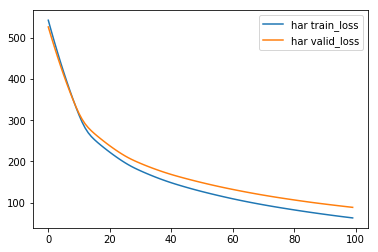

In [25]:
import matplotlib.pyplot as mplot
# % %matplotlib inline
# this is keeping the mpl inline or outline
# inline would inside this block and outline/out of block would be out of this block.
# %matplotlib inline
# %matplotlib
%matplotlib inline

mplot.plot(train_loss, label='har train_loss')
mplot.plot(valid_loss, label='har valid_loss')
mplot.legend()
mplot.show()

In [26]:
# Testing and playing around with checkpoints and trained model saved or saved trained model
# loaded_ckpt = tf.train.load_checkpoint(ckpt_dir_or_file='checkpoints/cnn-har.ckpt')
# loaded_ckpt.debug_string, 
# loaded_ckpt.get_variable_to_dtype_map()
# loaded_ckpt.get_variable_to_shape_map()

In [27]:
with tf.Session() as sess:
    # Restore the validated model
    save_path = tf.train.latest_checkpoint(checkpoint_dir='checkpoints')
    saver.restore(save_path=save_path, sess=sess)
    
    loss_batch = []
    for Xarr, Yarr in get_batches(X=X_test_norm, batch_size=N, y=Y_test_onehot):
        print(Xarr.shape, Yarr.shape)
        feed_dict = {X:Xarr, Y:Yarr}
        lossarr = sess.run(feed_dict=feed_dict, fetches=[loss])
        loss_batch.append(lossarr)

    # Print info for every iter/epoch
    print('test_loss:', np.mean(loss_batch))
#     print("Test loss: {:6f}".format(np.mean(test_loss))

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
(2206, 128, 9) (2206, 6)
test_loss: 111.4286
